# Generate consensus sequence

How to simplify graph to get consensus seq:
1. remove rare blocks (below rare block threshold), don't account for duplicates yet
2. Deduplicate blocks: blocks that are duplicated are set into their context, the context is defined by the closest non-duplicated, non-inverted block to the left
3. refilter rare blocks, now accounting for duplication (some blocks might have been overcounted before which didn't filter them in the first step)
4. filter out rare edges: remove isolate paths that contain rare edges below a second threshold, remaining unique paths are consensus paths
5. Filter out consensus paths that have less than min_n_isolates isolates assigned, e.g. min_n_isolates = 5

Assign isolates to consensus paths:
- the shared edge jaccard index is calculated between each consensus path and each isolate, paths are assigned to their most similar consensus path based on this measure


## Build graph

In [1]:
# set working directory to project folder
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import altair as alt
from itertools import combinations
import numpy as np
import pypangraph as pp
from Bio import Phylo, SeqIO
from Bio import Align
import string
import networkx as nx
import igraph as ig
import cairo

import scipy.cluster.hierarchy as sch
from collections import Counter

from junction_analyis.helpers import get_tree_order
import junction_analyis.pangraph_utils as pu
from junction_analyis.plotting import plot_junction_pangraph_combined
from junction_analyis.consensus import find_consensus_paths

In [3]:
_fname = f"../config/junction_stats.csv"
jdf = pd.read_csv(_fname)
jdf

edge  n_iso  n_blocks  has_dupl  n_categories  \
0    HUTOPWFGVH_f__WJBYSSJHSE_f    222         5     False             3   
1    IZQZNHJQRQ_f__ZVPGGEJIIF_f    222         3     False             2   
2    JNLRGIQXOF_f__YQUHGDANHE_f    222         3     False             2   
3    JMOMDSHCBS_r__SPDPCYMYDN_r    222         3     False             2   
4    JKRDVEYDGL_f__OTPJRRWJRK_f    222         3     False             2   
..                          ...    ...       ...       ...           ...   
543  GPXHVRRZLC_f__KYQOKYBCOW_f      2        12     False             2   
544  EOBHADSLFU_f__SKPHAXSFLS_r      2         1     False             1   
545  XXIWNZXZTK_f__ZLAJFQLBFQ_r      2         3     False             2   
546  YUOECYBHUS_f__ZTHKZYHPIX_f      2        20      True             2   
547  KIVDDRSTJR_f__QQSILILDBT_r      2         1     False             1   

     majority_category  singleton  cat_entropy  n_nodes  min_length  \
0                  218      False     0.100354       11       18177   
1                  221       True     0.028831        5       11740   
2                  221       True     0.028831        5       28035   
3                  220      False     0.051397        5        7366   
4                  221       True     0.028831        5       10058   
..                 ...        ...          ...      ...         ...   
543                  1       True     0.693147       18       65788   
544                  2      False     0.000000        1        7231   
545                  1       True     0.693147        6       83630   
546                  1       True     0.693147       35       66710   
547                  2      False     0.000000        1       11508   

     max_length    mean_length  n_all_cores  core_left_length  \
0         18954   18190.108108          218           16280.0   
1         12517   11743.500000          221            1530.0   
2         29472   28041.472973          221           23758.0   
3          8143    7373.000000          220            2781.0   
4         48233   10229.959459          221            7295.0   
..          ...            ...          ...               ...   
543      105315   85551.500000            0           18606.0   
544        7231    7231.000000            2            7231.0   
545       83630   83630.000000            2           31644.0   
546      186048  126379.000000            0           60232.0   
547       11508   11508.000000            2           11508.0   

     core_right_length  transitive  nonempty_acc_len  nonempty_freq  \
0               1699.0       False             727.5       0.018018   
1              10210.0       False             777.0       0.004505   
2               4277.0       False            1437.0       0.004505   
3               4585.0       False             777.0       0.009009   
4               2763.0       False           38175.0       0.004505   
..                 ...         ...               ...            ...   
543            29024.0       False           34255.5       1.000000   
544             7231.0        True               NaN       0.000000   
545            48921.0       False               NaN       0.000000   
546             5710.0       False           60437.0       1.000000   
547            11508.0        True               NaN       0.000000   

     pangenome_len  
0           1684.0  
1            768.0  
2           1433.0  
3            768.0  
4          37225.0  
..             ...  
543       100857.0  
544         3298.0  
545        73408.0  
546       160404.0  
547         1447.0  

[548 rows x 19 columns]

Found 18 unique paths.
Removing rare consensus path: consensus_9 (1 isolates)
Removing rare consensus path: consensus_10 (1 isolates)
Removing rare consensus path: consensus_5 (2 isolates)


(<Figure size 1200x5544 with 1 Axes>, <Axes: xlabel='genomic position (bp)'>)

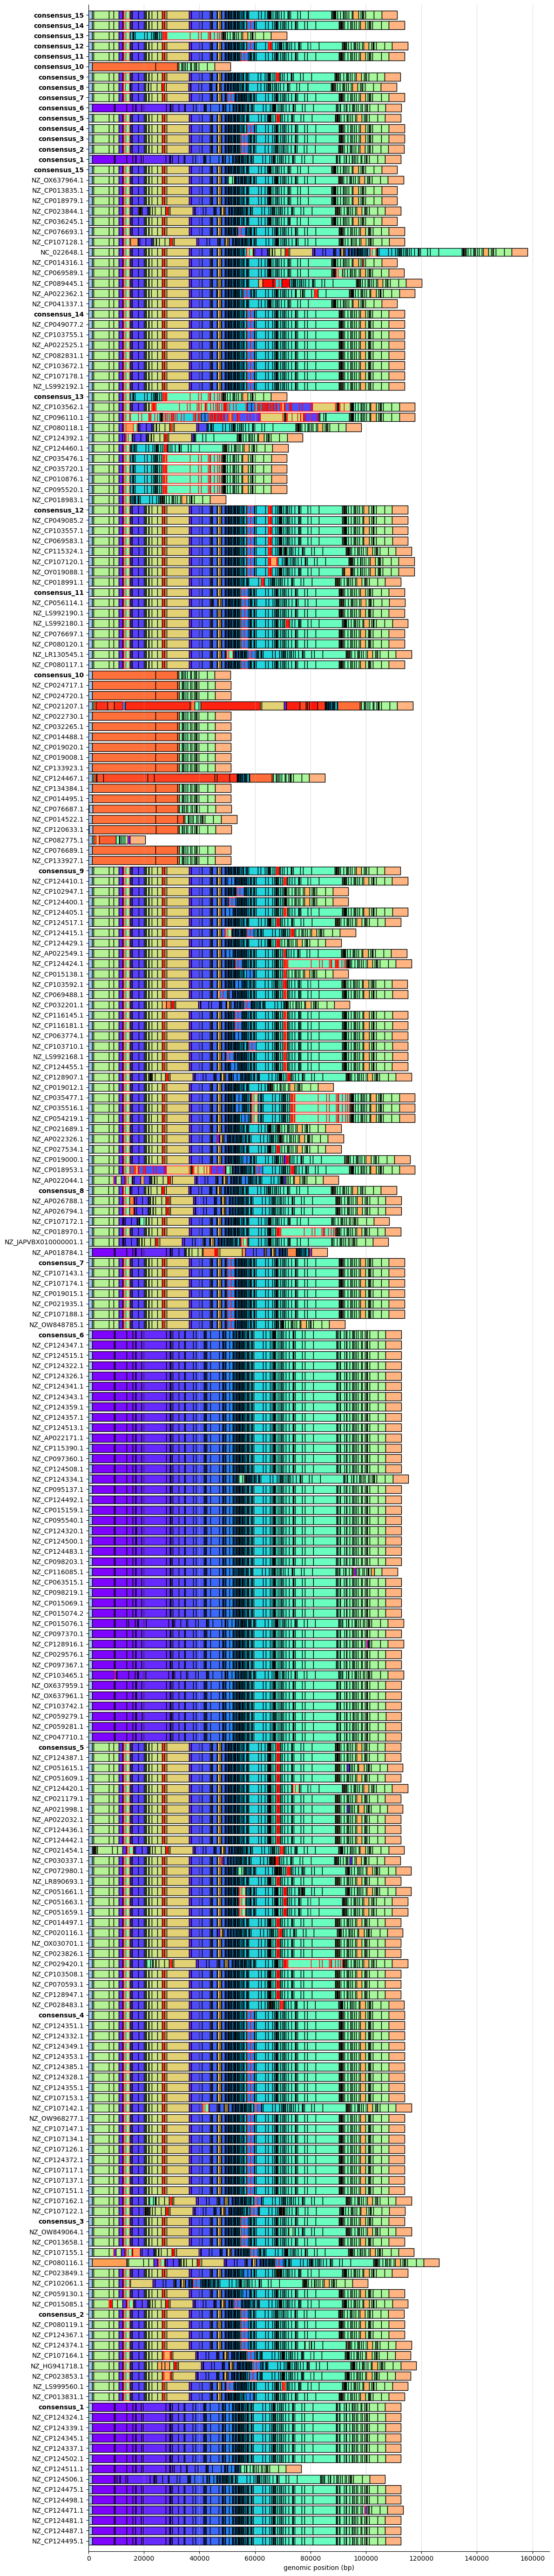

In [ ]:
example_junction = "RYYAQMEJGY_r__ZTHKZYHPIX_f"
example_pangraph = pp.Pangraph.from_json(f"../results/junction_pangraphs/{example_junction}.json")

consensus_paths, path_dict, similarity_matrix, assignment_df = find_consensus_paths(example_pangraph, rare_block_threshold=10, rare_edge_threshold=5, min_n_isolates_per_consensus=5)
#plot_junction_pangraph(example_pangraph, True, consensus_paths)
#plot_junction_pangraph_grouped(example_pangraph, consensus_paths, assignment_df)

plot_junction_pangraph_combined(
    example_pangraph,
    show_consensus=True,
    consensus_paths=consensus_paths,
    assignments=assignment_df,
    order="tree"
)

Found 3 unique paths.


(<Figure size 1200x5016 with 1 Axes>, <Axes: xlabel='genomic position (bp)'>)

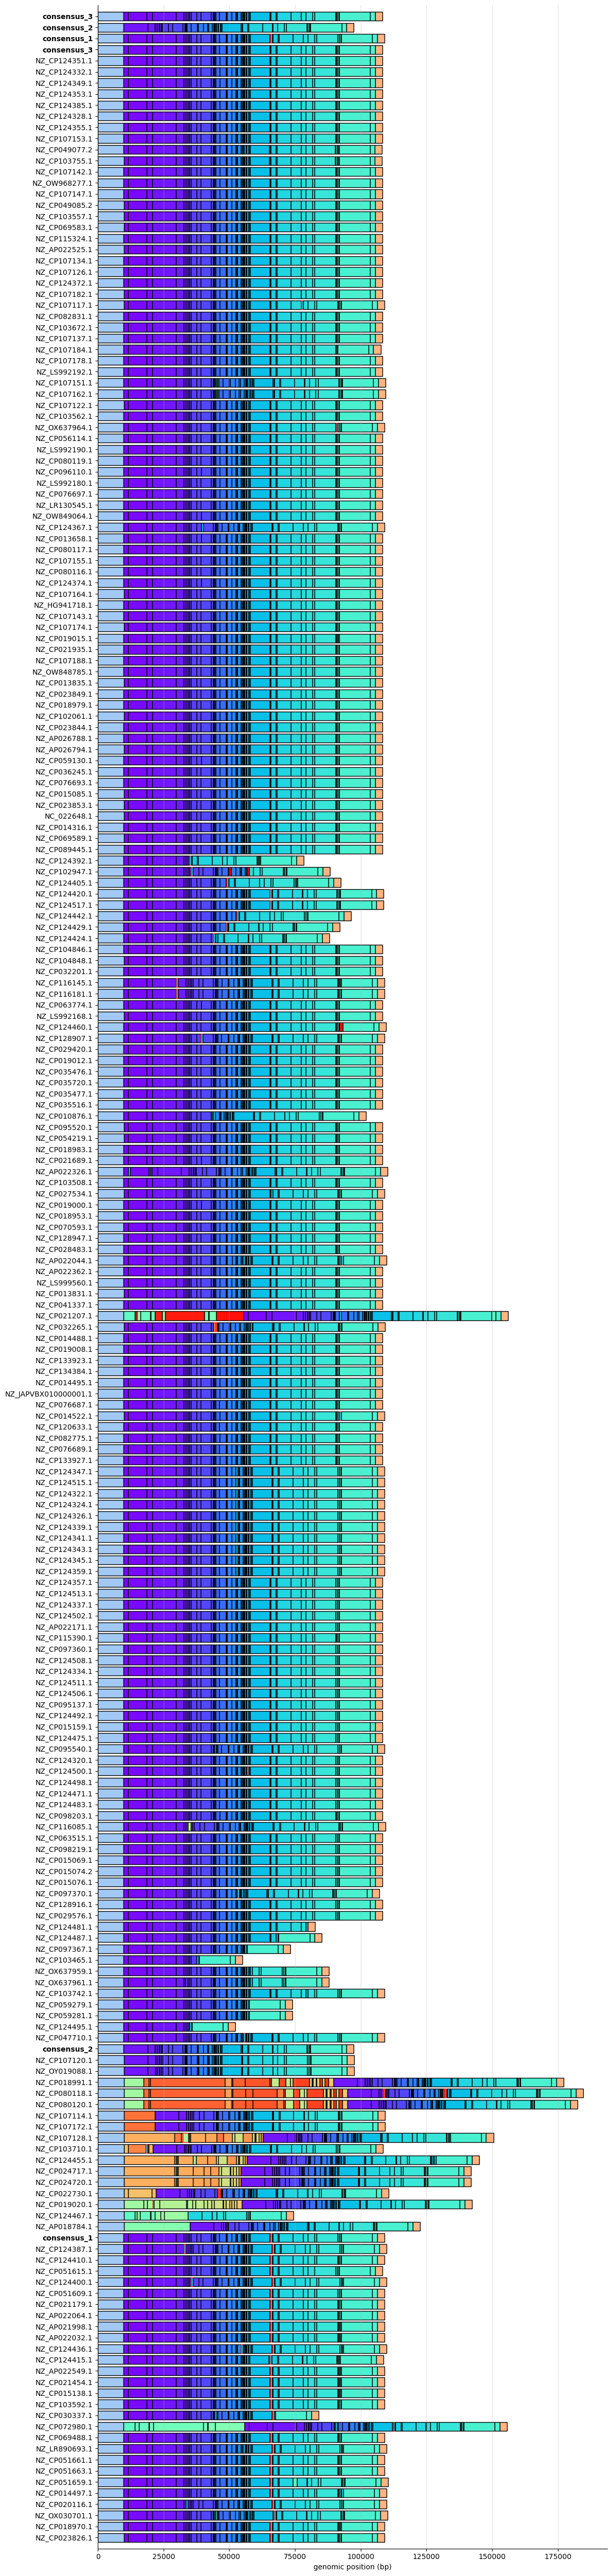

In [ ]:
example_junction = "EJPOGALASQ_f__KUIFCLFQSI_r"
example_pangraph = pp.Pangraph.from_json(f"../results/junction_pangraphs/{example_junction}.json")

consensus_paths, path_dict, similarity_matrix, assignment_df = find_consensus_paths(example_pangraph, rare_block_threshold=15, rare_edge_threshold=10, min_n_isolates_per_consensus=5)

plot_junction_pangraph_combined(
    example_pangraph,
    show_consensus=True,
    consensus_paths=consensus_paths,
    assignments=assignment_df,
    order="tree"
)

Found 3 unique paths.


(<Figure size 1200x5016 with 1 Axes>, <Axes: xlabel='genomic position (bp)'>)

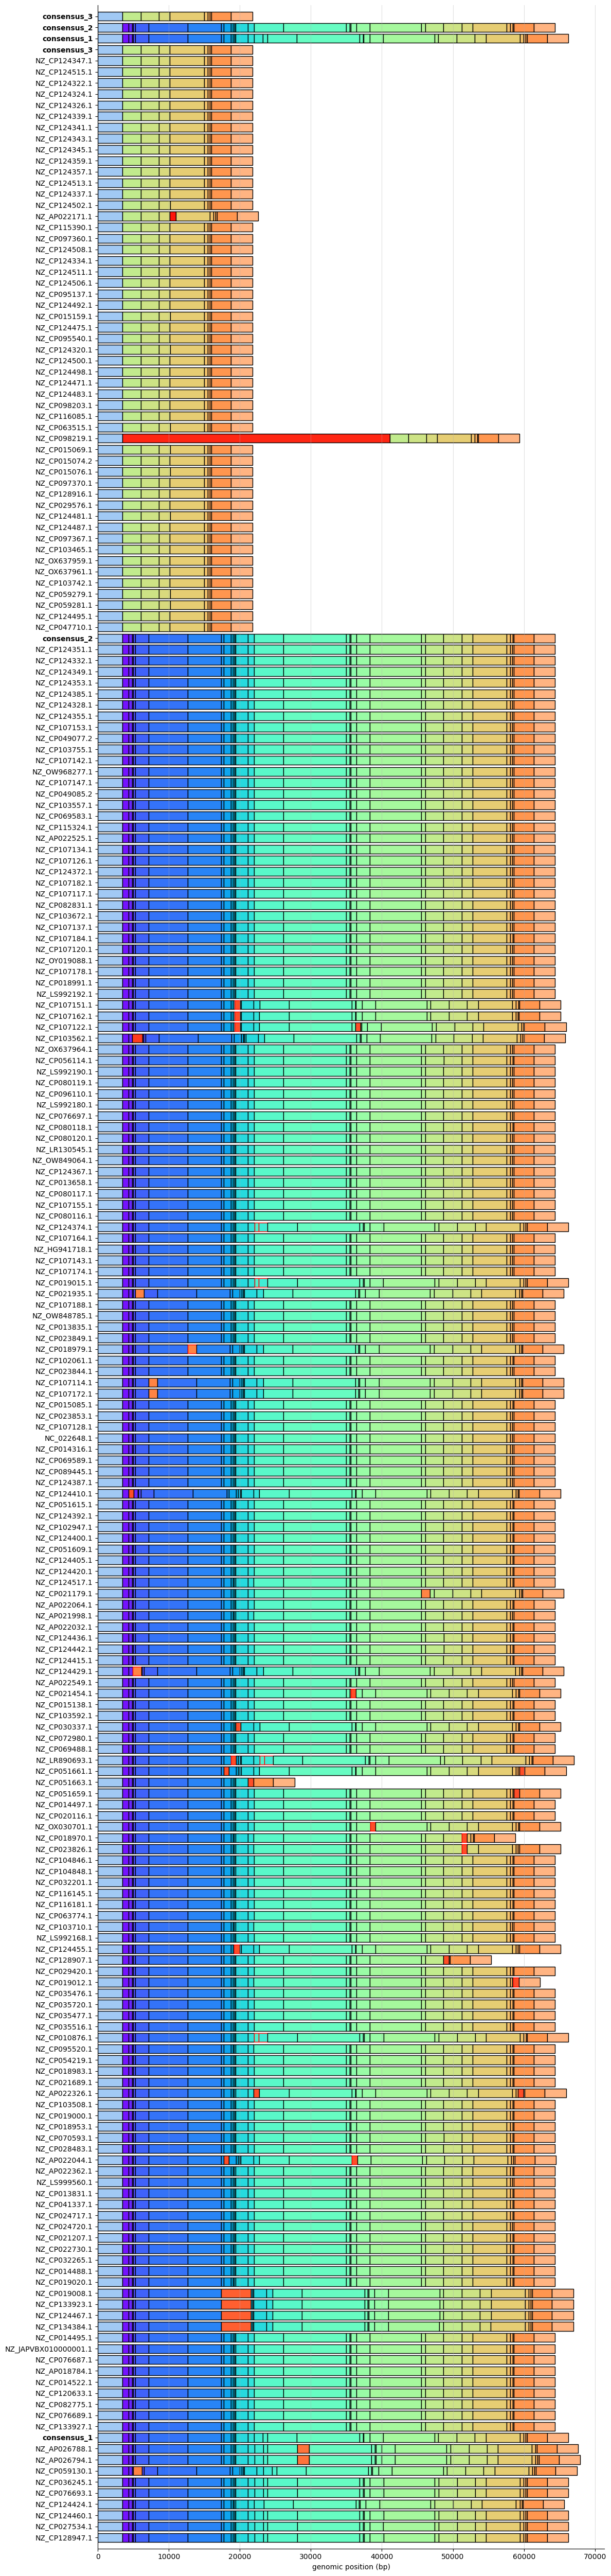

In [ ]:
example_junction = "CIRMBUYJFK_f__CWCCKOQCWZ_r"
example_pangraph = pp.Pangraph.from_json(f"../results/junction_pangraphs/{example_junction}.json")

consensus_paths, path_dict, similarity_matrix, assignment_df = find_consensus_paths(example_pangraph, rare_block_threshold=5, rare_edge_threshold=5, min_n_isolates_per_consensus=5)
plot_junction_pangraph_combined(
    example_pangraph,
    show_consensus=True,
    consensus_paths=consensus_paths,
    assignments=assignment_df,
    order="tree"
)

Found 3 unique paths.


(<Figure size 1200x5016 with 1 Axes>, <Axes: xlabel='genomic position (bp)'>)

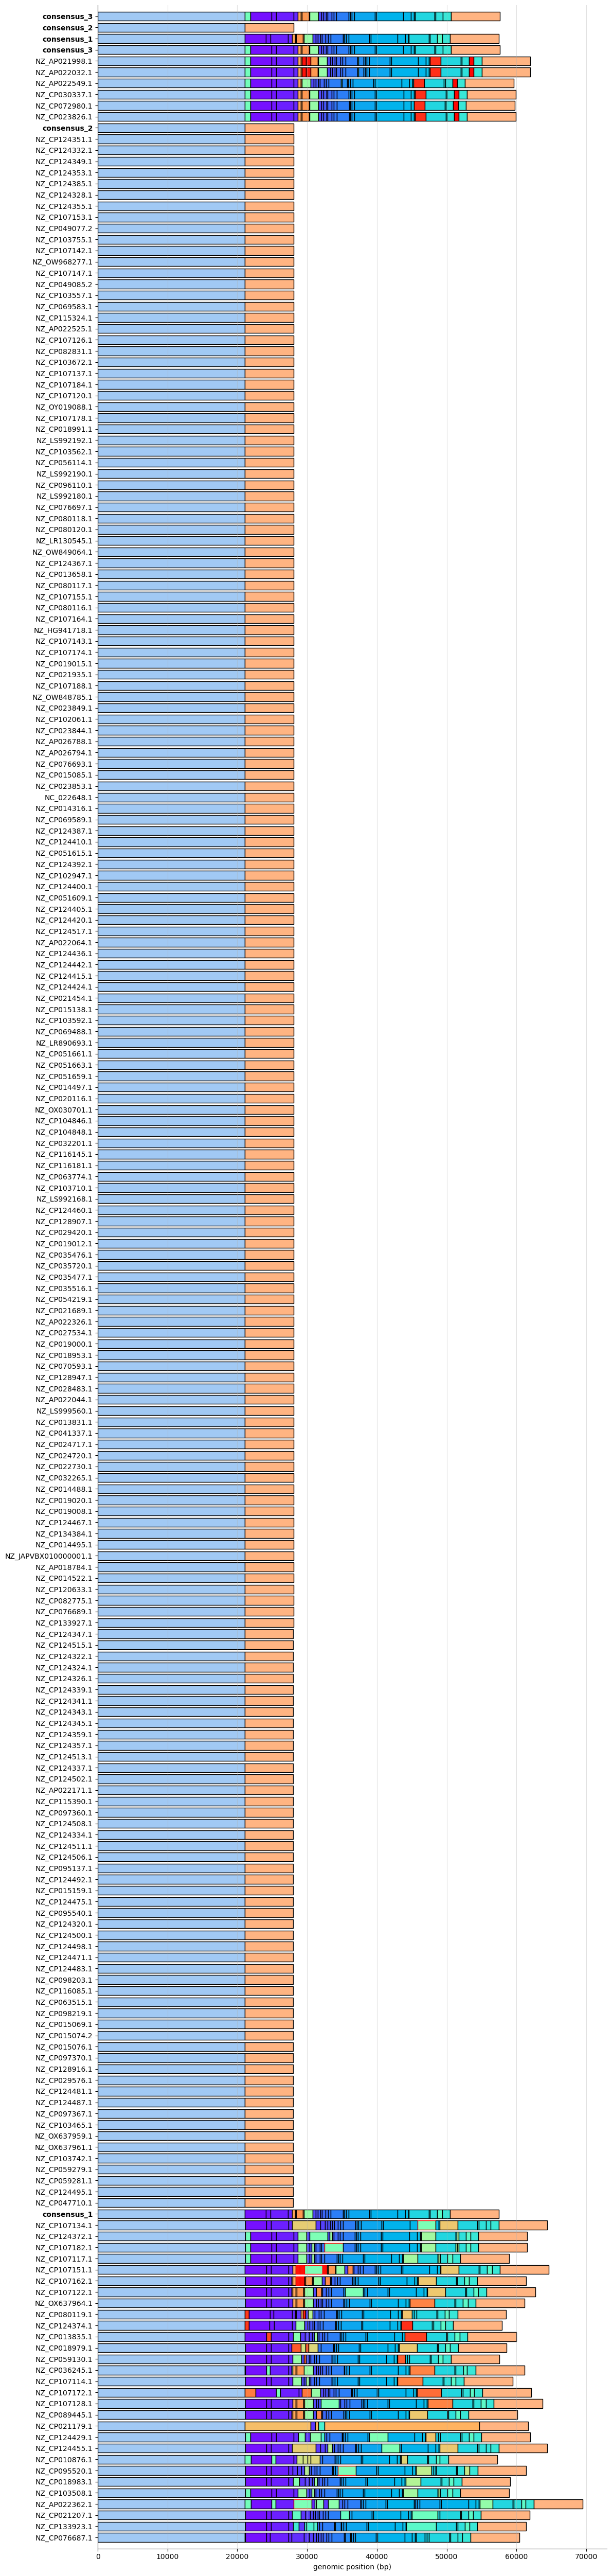

In [ ]:
example_junction = "ATPWUNKKID_f__KKPYPKGMXA_f"
example_pangraph = pp.Pangraph.from_json(f"../results/junction_pangraphs/{example_junction}.json")

consensus_paths, path_dict, similarity_matrix, assignment_df = find_consensus_paths(example_pangraph, rare_block_threshold=10, rare_edge_threshold=10, min_n_isolates_per_consensus=5)
plot_junction_pangraph_combined(
    example_pangraph,
    show_consensus=True,
    consensus_paths=consensus_paths,
    assignments=assignment_df,
    order="tree"
)